In [4]:
import gdown
import zipfile
import os

file_id = "1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.zip"

gdown.download(url, output, quiet=False)

# Extract
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Extracted files:", os.listdir("dataset"))


Downloading...
From (original): https://drive.google.com/uc?id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-
From (redirected): https://drive.google.com/uc?id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-&confirm=t&uuid=e0835d2b-e96e-48d9-b93c-43fd0de82514
To: /kaggle/working/dataset.zip

  0%|          | 0.00/1.78G [00:00<?, ?B/s]
  0%|          | 4.19M/1.78G [00:00<02:22, 12.4MB/s]
  1%|          | 13.6M/1.78G [00:00<00:48, 36.6MB/s]
  2%|▏         | 37.2M/1.78G [00:00<00:18, 95.6MB/s]
  3%|▎         | 51.4M/1.78G [00:00<00:16, 107MB/s] 
  4%|▍         | 76.0M/1.78G [00:00<00:11, 147MB/s]
  5%|▌         | 93.8M/1.78G [00:00<00:12, 137MB/s]
  6%|▌         | 110M/1.78G [00:01<00:12, 131MB/s] 
  7%|▋         | 129M/1.78G [00:01<00:11, 148MB/s]
  8%|▊         | 145M/1.78G [00:01<00:10, 151MB/s]
  9%|▉         | 167M/1.78G [00:01<00:10, 159MB/s]
 11%|█         | 191M/1.78G [00:01<00:08, 181MB/s]
 12%|█▏        | 210M/1.78G [00:01<00:09, 174MB/s]
 13%|█▎        | 228M/1.78G [00:01<00:09, 160MB/s]
 14%|█▍        |

Extracted files: ['Shop DataSet']


# Loading  Dataset

In [5]:
import os
import glob
import random
import math
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.utils import class_weight
from collections import Counter
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
tf.get_logger().setLevel('ERROR')

DATASET_PATH = "/kaggle/working/dataset/Shop DataSet"  
OUTPUT_DIR = "/kaggle/working"
NUM_FRAMES = 16     
IMG_SIZE = (96, 96)
BATCH_SIZE = 4    

EPOCHS = 40
SEED = 42
CACHE_PATH = os.path.join(OUTPUT_DIR, "shoplift_cache.npz")

try:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    print("Using mixed precision policy:", tf.keras.mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not available or failed to set. Using default float32. Error:", e)

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

os.makedirs(OUTPUT_DIR, exist_ok=True)

def find_videos(root):
    if not os.path.exists(root):
         raise FileNotFoundError(f"Dataset path not found: {root}")
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    if len(classes) != 2:
        raise ValueError(f"Expected exactly two class subfolders. Found: {classes}")

    class_to_label = {cls: idx for idx, cls in enumerate(classes)}
    filepaths, labels = [], []
    video_exts = {".mp4", ".avi", ".mov", ".mkv", ".wmv", ".flv", ".mpeg", ".mpg", ".m4v"}

    for idx, cls in enumerate(classes):
        paths = glob.glob(os.path.join(root, cls, "**", "*.*"), recursive=True)
        for p in paths:
            ext = os.path.splitext(p.lower())[1]
            if ext in video_exts:
                filepaths.append(p)
                labels.append(idx)
    return filepaths, np.array(labels, dtype=np.int32), classes

try:
    filepaths, labels, classes = find_videos(DATASET_PATH)
except FileNotFoundError as e:
    print(f"FATAL ERROR: {e}")
    raise
except ValueError as e:
    print(f"FATAL ERROR: {e}")
    raise

print(f"Found {len(filepaths)} videos in {classes}")
print("Class distribution:", Counter(labels.tolist()))


2025-10-10 14:45:20.137381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760107520.320472      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760107520.367171      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using mixed precision policy: <DTypePolicy "mixed_float16">
Found 855 videos in ['non shop lifters', 'shop lifters']
Class distribution: Counter({0: 531, 1: 324})


# Preprocessing 

In [6]:
def extract_uniform_frames(video_path, num_frames=NUM_FRAMES, resize=IMG_SIZE):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # If no frames, build empty sequence of zeros
    if total_frames <= 0:
        frames_out = [np.zeros((resize[0], resize[1], 3), dtype=np.uint8) for _ in range(num_frames)]
        cap.release()
        return np.array(frames_out, dtype=np.uint8)

    indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    frames_out = []
    last_valid = None

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if not ret or frame is None or frame.size == 0:
            # attempt to read next frame
            ret2, frame2 = cap.read()
            if ret2 and frame2 is not None and frame2.size > 0:
                frame = frame2
            else:
                frame = last_valid.copy() if last_valid is not None else np.zeros((resize[0], resize[1], 3), dtype=np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (resize[1], resize[0]))
        frames_out.append(frame)
        last_valid = frame

    cap.release()

    # pad if necessary
    while len(frames_out) < num_frames:
        pad_frame = frames_out[-1].copy() if len(frames_out) > 0 else np.zeros((resize[0], resize[1], 3), dtype=np.uint8)
        frames_out.append(pad_frame)

    return np.array(frames_out[:num_frames], dtype=np.uint8)

if os.path.exists(CACHE_PATH):
    print("Loading preprocessed data from cache:", CACHE_PATH)
    data = np.load(CACHE_PATH, allow_pickle=True)
    X, y = data['X'], data['y']
else:
    print("Preprocessing videos (this may take a while) ...")
    X_list, y_list = [], []
    indices_perm = np.arange(len(filepaths))
    np.random.shuffle(indices_perm)

    for idx in tqdm(indices_perm, total=len(indices_perm)):
        path = filepaths[idx]
        lab = labels[idx]
        try:
            frames = extract_uniform_frames(path, num_frames=NUM_FRAMES, resize=IMG_SIZE)
            X_list.append(frames)
            y_list.append(lab)
        except Exception as e:
            print(f"\nError processing {path} -> {e}")

    if len(X_list) == 0:
        raise RuntimeError("No videos were successfully preprocessed. Check dataset path and video formats.")

    X = np.stack(X_list, axis=0)       # (N_videos, NUM_FRAMES, H, W, 3)
    y = np.array(y_list, dtype=np.int32)

    print("Saving preprocessed arrays to", CACHE_PATH)
    np.savez_compressed(CACHE_PATH, X=X, y=y)

print("Shapes: X =", X.shape, "y =", y.shape)

Preprocessing videos (this may take a while) ...



100%|██████████| 855/855 [07:02<00:00,  2.02it/s]


Saving preprocessed arrays to /kaggle/working/shoplift_cache.npz
Shapes: X = (855, 16, 96, 96, 3) y = (855,)


# Normalize then standardize & Train/Val/Test Split and Oversampling

In [7]:
X = X.astype(np.float32) / 255.0
all_pixels = X.reshape(-1, 3)
mean = all_pixels.mean(axis=0)
std = all_pixels.std(axis=0) + 1e-8
print(f"Per-channel mean: {mean}, std: {std}")
# Standardize
X = (X - mean) / std

test_size = 0.15
val_size_relative = 0.1 / (1.0 - test_size)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=val_size_relative, stratify=y_train_full, random_state=SEED
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Initial Train class counts:", Counter(y_train.tolist()))

Per-channel mean: [0.13307342 0.13307342 0.13307342], std: [0.2739229  0.26871088 0.27151367]
Train: (640, 16, 96, 96, 3) Val: (86, 16, 96, 96, 3) Test: (129, 16, 96, 96, 3)
Initial Train class counts: Counter({0: 398, 1: 242})


# balance classes 

In [8]:
USE_OVERSAMPLING = True      
USE_CLASS_WEIGHTS = True 
def oversample_minority(X_arr, y_arr):
    counts = Counter(y_arr.tolist())
    max_count = max(counts.values())
    X_chunks = []
    y_chunks = []
    for cls, cnt in counts.items():
        idxs = np.where(y_arr == cls)[0]
        cur_count = len(idxs)
        if cur_count == 0:
            continue
        reps = max_count // cur_count
        rem = max_count - (cur_count * reps)
        for _ in range(reps):
            X_chunks.append(X_arr[idxs])
            y_chunks.append(np.full(cur_count, cls, dtype=np.int32))
        if rem > 0:
            chosen = np.random.choice(idxs, rem, replace=True)
            X_chunks.append(X_arr[chosen])
            y_chunks.append(np.full(rem, cls, dtype=np.int32))
    X_new = np.concatenate(X_chunks, axis=0)
    y_new = np.concatenate(y_chunks, axis=0)
    perm = np.random.permutation(len(X_new))
    return X_new[perm], y_new[perm]

if USE_OVERSAMPLING:
    print("Oversampling minority classes on training set to balance classes.")
    X_train, y_train = oversample_minority(X_train, y_train)
    print("New train class counts:", Counter(y_train.tolist()))

class_weights_dict = None
if USE_CLASS_WEIGHTS and len(np.unique(y_train)) > 1:
    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {int(cls): float(w) for cls, w in zip(np.unique(y_train), cw)}
    print("Class weights:", class_weights_dict)

Oversampling minority classes on training set to balance classes.
New train class counts: Counter({1: 398, 0: 398})
Class weights: {0: 1.0, 1: 1.0}


# Model With Agumentation 

In [16]:
def build_frame_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (5,5), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(192, activation='relu')(x)
    return models.Model(inp, x, name='deep_frame_cnn')

def build_cnn_lstm_model(seq_len=NUM_FRAMES, frame_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)):
    frame_cnn = build_frame_cnn(input_shape=frame_shape)
    seq_input = layers.Input(shape=(seq_len, frame_shape[0], frame_shape[1], frame_shape[2]))
    td = layers.TimeDistributed(frame_cnn)(seq_input)
    x = layers.Bidirectional(layers.LSTM(192, return_sequences=False))(td)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    return models.Model(inputs=seq_input, outputs=out, name='strong_cnn_lstm_model')

model = build_cnn_lstm_model()
model.summary()
optimizer = optimizers.Adam(learning_rate=3e-4)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

AUGMENT_DURING_TRAIN = True 
def augment_frames_np(frames):
    frames = frames.copy()
    if np.random.rand() > 0.5: 
        frames = frames[:, :, ::-1, :]
    contrast_factor = np.random.uniform(0.9, 1.1)
    brightness_add = np.random.uniform(-0.05, 0.05)
    frames = (frames * contrast_factor) + brightness_add
    
    if np.random.rand() > 0.7:
        shift = np.random.randint(-3, 3)
        if shift > 0:
            frames = np.concatenate([np.repeat(frames[0][np.newaxis, ...], shift, axis=0), frames[:-shift]], axis=0)
        elif shift < 0:
            frames = np.concatenate([frames[-shift:], np.repeat(frames[-1][np.newaxis, ...], -shift, axis=0)], axis=0)
    return frames.astype(np.float32)

if class_weights_dict is not None:
    sample_weights_train = np.array([class_weights_dict[int(lbl)] for lbl in y_train], dtype=np.float32)
else:
    sample_weights_train = np.ones(len(y_train), dtype=np.float32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

def augment_map_tf(x, y, w):
    x_aug = tf.numpy_function(func=augment_frames_np, inp=[x], Tout=tf.float32)
    x_aug.set_shape((NUM_FRAMES, IMG_SIZE[0], IMG_SIZE[1], 3))
    return x_aug, tf.cast(y, tf.int32), tf.cast(w, tf.float32)

if AUGMENT_DURING_TRAIN:
    train_ds = train_ds.map(augment_map_tf, num_parallel_calls=tf.data.AUTOTUNE)
else:
    train_ds = train_ds.map(lambda x,y,w: (tf.cast(x, tf.float32), tf.cast(y, tf.int32), tf.cast(w, tf.float32)),
                            num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.int32)), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.int32)), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=len(X_train), seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

checkpoint_path = os.path.join(OUTPUT_DIR, 'best_scratch_cnn_lstm.weights.h5')
cb_early = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
cb_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, min_lr=1e-6)
cb_ckpt = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=True)

print("\n" + "="*50)
print("Starting Training...")
print("="*50 + "\n")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[cb_reduce, cb_ckpt],
    verbose=1
)

try:
    model.load_weights(checkpoint_path)
    print(f"Loaded best weights from {checkpoint_path} for final evaluation.")
except Exception as e:
    print(f"Could not load best weights from checkpoint. Using final epoch weights. Error: {e}")

print("\n" + "="*50)
print("Evaluating on Validation Set for Threshold Selection...")
print("="*50 + "\n")

y_val_prob = model.predict(val_ds).flatten()
y_val_true = y_val.astype(int)

if len(y_val_true) > 0:
    thresholds = np.linspace(0.01, 0.99, 99)
    best_f1, best_th = -1.0, 0.5
    for th in thresholds:
        preds = (y_val_prob >= th).astype(int)
        f1 = f1_score(y_val_true, preds, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
    print(f"Best threshold on val (max F1): {best_th:.3f} (F1={best_f1:.4f})")
else:
    best_th = 0.5
    print("Warning: Validation set is empty. Defaulting threshold to 0.5.")
# Save full model (architecture + weights + optimizer)
final_model_path = os.path.join(OUTPUT_DIR, 'final_shoplifting_model.keras')
model.save(final_model_path)
print(f"\n Final model saved to: {final_model_path}")

Model: "strong_cnn_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16, 96, 96, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_7 (Cast)                   │ (None, 16, 96, 96, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 192)        │     1,160,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 384)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_8 (Cast)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,801,665 (6.87 MB)

 Trainable params: 1,801,665 (6.87 MB)

 Non-trainable params: 0 (0.00 B)


Starting Training...

Epoch 1/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5160 - auc: 0.5040 - loss: 0.6989
Epoch 1: val_loss improved from inf to 0.69493, saving model to /kaggle/working/best_scratch_cnn_lstm.weights.h5
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - accuracy: 0.5160 - auc: 0.5040 - loss: 0.6989 - val_accuracy: 0.3837 - val_auc: 0.5000 - val_loss: 0.6949 - learning_rate: 3.0000e-04
Epoch 2/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4921 - auc: 0.5039 - loss: 0.6928
Epoch 2: val_loss improved from 0.69493 to 0.69315, saving model to /kaggle/working/best_scratch_cnn_lstm.weights.h5
199/199 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.4922 - auc: 0.5039 - loss: 0.6928 - val_accuracy: 0.4302 - val_auc: 0.5000 - val_loss: 0.6931 - learning_rate: 3.0000e-04
Epoch 3/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5270 - auc: 0.5348 - loss: 0.6947
Epoch 3: val_loss did not improve from 0.69315
199/199 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/s

# Final Evaluation on Test Set 

In [19]:

print("\n" + "="*50)
print("Final Evaluation on Test Set...")
print("="*50 + "\n")

y_test_prob = model.predict(test_ds).flatten()
y_test_true = y_test.astype(int)
y_test_pred = (y_test_prob >= best_th).astype(int)

if len(y_test_true) > 0:
    print("Classification report (using threshold {:.3f}):".format(best_th))
    print(classification_report(y_test_true, y_test_pred, target_names=classes, digits=4, zero_division=0))
else:
    print("Warning: Test set is empty. Skipping final evaluation.")


Final Evaluation on Test Set...

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification report (using threshold 0.260):
                  precision    recall  f1-score   support

non shop lifters     1.0000    0.9750    0.9873        80
    shop lifters     0.9608    1.0000    0.9800        49

        accuracy                         0.9845       129
       macro avg     0.9804    0.9875    0.9837       129
    weighted avg     0.9851    0.9845    0.9846       129



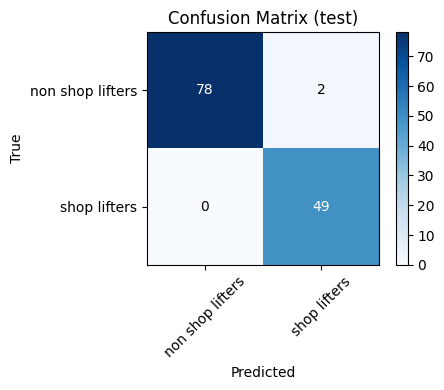

In [20]:
if len(y_test_true) > 0:
    cm = confusion_matrix(y_test_true, y_test_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (test)")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted'); plt.ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.tight_layout()
    plt.show()

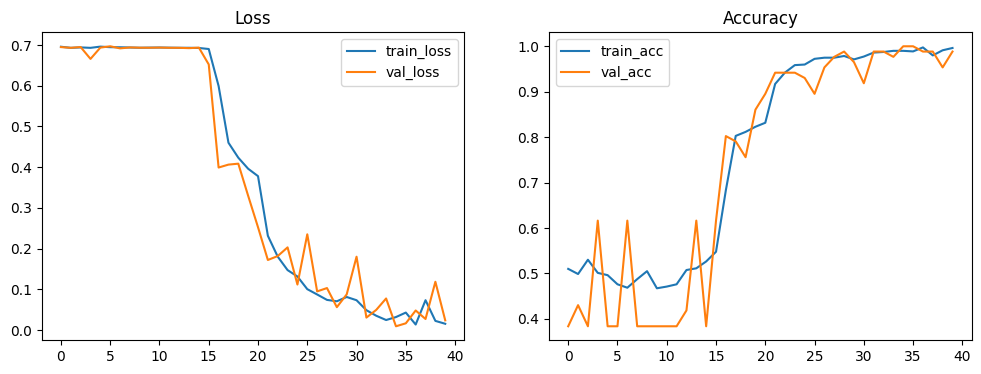

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()